In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

load parquetfile from notebook 01.

In [34]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'directories': {'raw': 'data/raw',
  'processed': 'data/processed',
  'input': '_chat.txt',
  'current': 'whatsapp-20251013-212815.parq',
  'preprocess_csv': 'whatsapp-20251018-161422-preprocess.csv',
  'preprocess_parq': 'whatsapp-20251018-161422-preprocess.parq',
  'cleaned_csv': 'whatsapp-20251018-161422-cleaned.csv',
  'cleaned_parq': 'whatsapp-20251018-161422-cleaned.parq',
  'feature_engineered_csv': 'whatsapp-20251018-161422-feature.csv',
  'feature_engineered_parq': 'whatsapp-20251018-161422-feature.parq',
  'categories_plot_png': 'categories_plot.png',
  'distribution_plot_png': 'distribution_plot.png',
  'correlation_plot_png': 'correlation_plot.png',
  'datetime_format': '%d-%m-%Y %H:%M',
  'drop_authors': []}}

In [35]:
root = Path("..").resolve()
# Access 'processed' inside the 'directories' key
processed = root / Path(config["directories"]["processed"]) 
datafile = processed / config["directories"]["feature_engineered_parq"]

if not datafile.exists():
    logger.warning(
        f"{datafile} does not exist. First run src/preprocess.py, and check the timestamp!"
    )

Show datatypes

In [36]:
df = pd.read_parquet(datafile)
df.dtypes

timestamp                datetime64[ns, UTC]
message                               object
living_in_city                         int64
tech_background                        int64
author                                object
year                                   int32
month                                  int32
week                                  UInt32
day                                    int32
hour                                   int32
minute                                 int32
day_of_week                           object
is_weekend                             int64
word_count                             int64
react_time_sec                       float64
react_time_sec_plus_1                float64
react_time_sec_log                   float64
react_time_min                       float64
react_time_min_plus_1                float64
react_time_min_log                   float64
react_time_hr                        float64
react_time_hr_plus_1                 float64
react_time

In [19]:
df.head()

,timestamp,message,living_in_city,tech_background,author,year,month,day,hour,minute,...,react_time_hr,react_time_hr_plus_1,react_time_hr_log,is_image,is_empty_message,is_removed_message,has_emoji,emoji_count,sentiment_polarity,sentiment_category
0,2022-09-16 07:31:00+00:00,Wachten op dit bericht,1,1,spattered-duck,2022,9,16,7,31,...,NaN,NaN,NaN,0,1,0,0,0,0.0,Neutral
1,2022-09-16 07:41:00+00:00,Wachten op dit bericht,0,1,riotous-dingo,2022,9,16,7,41,...,0.166667,1.166667,0.154151,0,1,0,0,0,0.0,Neutral
2,2022-09-16 08:21:00+00:00,Wachten op dit bericht,0,0,translucent-dog,2022,9,16,8,21,...,0.666667,1.666667,0.510826,0,1,0,0,0,0.0,Neutral
3,2022-09-16 08:23:00+00:00,Wachten op dit bericht,0,0,hypnotic-rabbit,2022,9,16,8,23,...,0.033333,1.033333,0.032790,0,1,0,0,0,0.0,Neutral
4,2022-09-16 09:08:00+00:00,Wachten op dit bericht,0,1,crystalline-uakari,2022,9,16,9,8,...,0.750000,1.750000,0.559616,0,1,0,0,0,0.0,Neutral


Show on what days the questions are asked

In [38]:
# show number of texts, number of texts where question = 1, meeting_up is 1 and question =1 + meeting_up = 1
total_texts = len(df)
question_texts = len(df[df['is_question'] == 1])
meeting_up_texts = len(df[df['mentions_meet_up'] == 1])
question_meeting_up_texts = len(df[(df['is_question'] == 1) & (df['mentions_meet_up'] == 1)])

logger.info(f"Total texts: {total_texts}")
logger.info(f"Texts with questions: {question_texts} ({question_texts/total_texts:.2%})")
logger.info(f"Texts about meeting up: {meeting_up_texts} ({meeting_up_texts/total_texts:.2%})")
logger.info(f"Texts with questions about meeting up: {question_meeting_up_texts} ({question_meeting_up_texts/total_texts:.2%})")

2025-11-09 18:19:10.380 | INFO     | __main__:<module>:7 - Total texts: 10136
2025-11-09 18:19:10.381 | INFO     | __main__:<module>:8 - Texts with questions: 1336 (13.18%)
2025-11-09 18:19:10.387 | INFO     | __main__:<module>:9 - Texts about meeting up: 856 (8.45%)
2025-11-09 18:19:10.388 | INFO     | __main__:<module>:10 - Texts with questions about meeting up: 267 (2.63%)


In [ ]:
# Give me 15 texts where is_question == 1 and mentions_meet_up == 1
df_questions_meetup = df[(df['is_question'] == 1) & (df['mentions_meet_up'] == 1)]
df_questions_meetup_sample = df_questions_meetup.sample(n=15, random_state=42)
print(df_questions_meetup_sample[['message', 'is_question', 'mentions_meet_up']])

                                                 message  is_question  \
2936          Hoe laat zullen we afspreken in Groningen?            1   
1456                    Lekker pilsje pakken bij iemand?            1   
8022                          Iemand pilsje dit weekend?            1   
9432                Wie willen er vnv een biertje doen??            1   
7833   Wie zijn er vanavond allemaal? Als in, hoeveel...            1   
8960   Wie willen er vrijdag allemaal na de doorloop ...            1   
2037   Zullen we vnv cafetje pakken in oldenzaal een ...            1   
10019  Heren, even een vraagje, hebben jullie zo een ...            1   
8239                     Hoe laat afspreken in Enschede?            1   
4786   Heey mannen, heb een vraagje aan jullie. Wie w...            1   
8205   Mannen, ik ben in het weekend 6-8 even in NL d...            1   
5188                Wie morgenavond een biertje drinken?            1   
9997   Ander vraagje, hoe laat willen we grofweg wa

In [41]:
# Give me 15 texts where is_question == 0 and mentions_meet_up == 1
df_questions_meetup = df[(df['is_question'] == 0) & (df['mentions_meet_up'] == 1)]
df_questions_meetup_sample = df_questions_meetup.sample(n=15, random_state=42)
print(df_questions_meetup_sample[['message', 'is_question', 'mentions_meet_up']])

                                                message  is_question  \
9431  Ben weekendje weg met Malu dus ben er dit week...            0   
5786                                        Ik niet vnv            0   
9386               Ik ben dit weekend in Amsterdam man!            0   
6675  Ja ik ga toch niet mee, dacht dat het misschie...            0   
4256                           Heeft er iemand nog pils            0   
2036  Ik kan dit weekend niet maar was meer om binne...            0   
5916                 Ik kan dit weekend helaas niet man            0   
3748  Zet er maar in de agenda dan beide zaterdagen ...            0   
9711                  Hahaha ja, werk in ruil voor pils            0   
2700  Ik ben er de 17e thijs, komend weekend heb ik ...            0   
9714                   Ik ben vnv al richting Zandvoort            0   
1533  Maak het trouwens niet laat vnv, morgen om 5 u...            0   
7943                                Ik kan vanavond wel         

Show percentage of meeting_up_questions coming from non_city_living

<>:56: SyntaxWarning: invalid escape sequence '\_'
<>:66: SyntaxWarning: invalid escape sequence '\_'
<>:56: SyntaxWarning: invalid escape sequence '\_'
<>:66: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipykernel_1964/1323223162.py:56: SyntaxWarning: invalid escape sequence '\_'
  label='Non-City Living (living\_in\_city = 0)',
/tmp/ipykernel_1964/1323223162.py:66: SyntaxWarning: invalid escape sequence '\_'
  label='City Living (living\_in\_city = 1)',


   year  total_meeting_up_questions  pct_non_city_living  pct_city_living
0  2022                          36            33.333333        66.666667
1  2023                          88            39.772727        60.227273
2  2024                          84            50.000000        50.000000
3  2025                          59            42.372881        57.627119


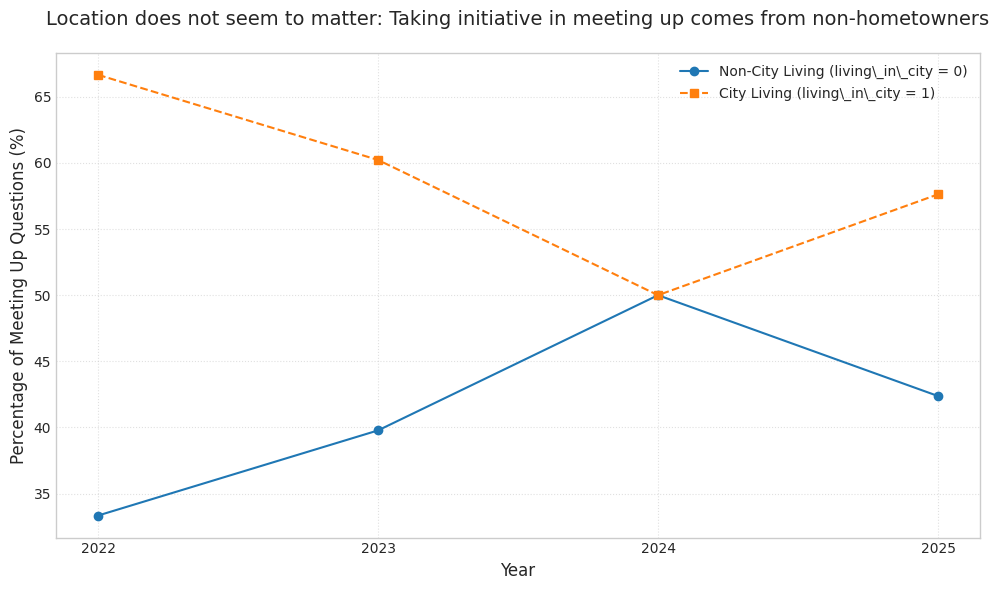

In [ ]:
# 1. Ensure the combined flag is correctly calculated
# (You already had this step, it's good practice to keep it explicit)
df['is_meeting_up_question'] = (
    (df['is_question'] == 1) & (df['mentions_meet_up'] == 1)
).astype(int)

# 2. Group by both 'year' and the condition ('is_city_living') and sum the questions
yearly_counts = df.groupby(['year', 'living_in_city'])[
    'is_meeting_up_question'
].sum().reset_index()

# 3. Pivot the table to get the city/non-city counts as separate columns
yearly_stats = yearly_counts.pivot(
    index='year',
    columns='living_in_city',
    values='is_meeting_up_question'
).fillna(0).reset_index()

# 4. Rename columns for clarity (0 is non_city, 1 is city)
yearly_stats.columns = [
    'year', 
    'meeting_up_questions_non_city', 
    'meeting_up_questions_city'
]

# 5. Calculate the total meeting up questions
yearly_stats['total_meeting_up_questions'] = (
    yearly_stats['meeting_up_questions_non_city'] + yearly_stats['meeting_up_questions_city']
)

# 6. Calculate the percentages (%)
# We use .div() for clarity and efficiency when dividing multiple columns
yearly_stats[['pct_non_city_living', 'pct_city_living']] = (
    yearly_stats[['meeting_up_questions_non_city', 'meeting_up_questions_city']]
    .div(yearly_stats['total_meeting_up_questions'], axis=0) * 100
)

# Handle cases where total_meeting_up_questions is 0 (division by zero results in NaN)
yearly_stats[['pct_non_city_living', 'pct_city_living']] = yearly_stats[
    ['pct_non_city_living', 'pct_city_living']
].fillna(0)

# 7. Print the final required result
print(yearly_stats[['year', 'total_meeting_up_questions', 'pct_non_city_living', 'pct_city_living']])

# --- START: Plotting Code ---

# Set up the plot size and style
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

# Plot the Non-City Living percentage
plt.plot(
    yearly_stats['year'],
    yearly_stats['pct_non_city_living'],
    label='Non-City Living (living\_in\_city = 0)',
    marker='o',
    linestyle='-',
    color='#1f77b4' # Muted blue
)

# Plot the City Living percentage
plt.plot(
    yearly_stats['year'],
    yearly_stats['pct_city_living'],
    label='City Living (living\_in\_city = 1)',
    marker='s',
    linestyle='--',
    color='#ff7f0e' # Orange
)

# Set the title, labels, and tick formatting
plot_title = "Location does not seem to matter: Taking initiative in meeting up comes from non-hometowners"
plt.title(plot_title, fontsize=14, pad=20)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Meeting Up Questions (%)", fontsize=12)

# Ensure X-axis ticks are integers for years
plt.xticks(yearly_stats['year'].astype(int))

# Add a legend to distinguish the lines
plt.legend(loc='upper right', fontsize=10)

# Add a grid for better readability
plt.grid(True, linestyle=':', alpha=0.6)

# Improve layout and display the plot
plt.tight_layout()
plt.show()

# --- END: Plotting Code ---

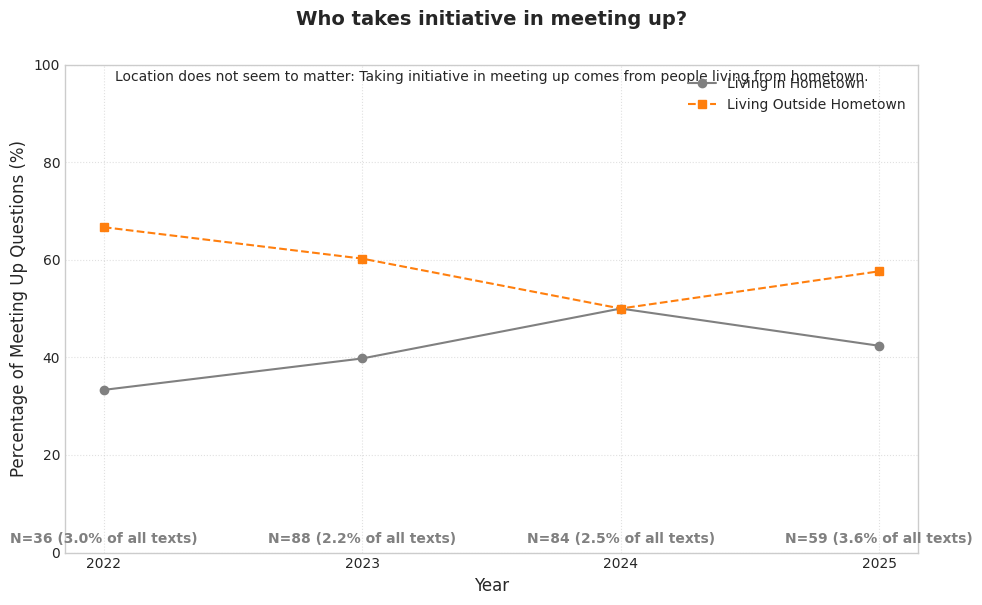

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# --- START: Data Preparation (Your provided steps) ---
df['is_meeting_up_question'] = ((df['is_question'] == 1) & (df['mentions_meet_up'] == 1)).astype(int)

yearly_texts = df.groupby('year').size().reset_index(name='total_texts_per_year')
yearly_counts = df.groupby(['year', 'living_in_city'])[
    'is_meeting_up_question'
].sum().reset_index()

yearly_stats = yearly_counts.pivot(
    index='year',
    columns='living_in_city',
    values='is_meeting_up_question'
).fillna(0).reset_index()

yearly_stats.columns = [
    'year',
    'meeting_up_questions_non_city',
    'meeting_up_questions_city'
]

yearly_stats['total_meeting_up_questions'] = (
    yearly_stats['meeting_up_questions_non_city'] + yearly_stats['meeting_up_questions_city']
)

yearly_stats['meeting_up_questions_total'] = (
    (yearly_stats['total_meeting_up_questions'] / yearly_texts['total_texts_per_year'] * 100)
).round(1)

yearly_stats[['pct_non_city_living', 'pct_city_living']] = (
    yearly_stats[['meeting_up_questions_non_city', 'meeting_up_questions_city']]
    .div(yearly_stats['total_meeting_up_questions'], axis=0) * 100
).fillna(0)
# --- END: Data Preparation ---


# --- START: Plotting Code ---

# Set up the plot size and style
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

# Plot the Non-City Living percentage
plt.plot(
    yearly_stats['year'],
    yearly_stats['pct_non_city_living'],
    label='Living in Hometown',
    marker='o',
    linestyle='-',
    color='#808080' # Grey
)

# Plot the City Living percentage
plt.plot(
    yearly_stats['year'],
    yearly_stats['pct_city_living'],
    label='Living Outside Hometown',
    marker='s',
    linestyle='--',
    color='#ff7f0e' # Orange
)

# --- NEW: Add Total N (Sample Size) for each year ---
# Define a fixed Y position for the N-count text (e.g., 2% above the x-axis)
y_text_position = 2

for index, row in yearly_stats.iterrows():
    # Use plt.text to add the 'N=' label and the total count
    plt.text(
        x=row['year'],
        y=y_text_position,
        s=f"N={int(row['total_meeting_up_questions'])} ({str(row['meeting_up_questions_total'])}% of all texts)",
        ha='center', # Center horizontally
        fontsize=10,
        color='gray',
        fontweight='bold'
    )

# Set the title, labels, and tick formatting
plot_title = "Who takes initiative in meeting up?"
plot_subtitle = "Location does not seem to matter: Taking initiative in meeting up comes from people living from hometown."
plt.suptitle(plot_title, fontsize=14, y=1.00, fontweight='bold') # Main title (largest font)
plt.title(plot_subtitle, fontsize=10, y=0.95) # Subtitle (smaller font, closer to the plot)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Meeting Up Questions (%)", fontsize=12)

# Ensure X-axis ticks are integers for years
plt.xticks(yearly_stats['year'].astype(int))

# Adjust y-axis limit to ensure the N-values are visible at the bottom
plt.ylim(0, 100) 

# Add a legend to distinguish the lines
plt.legend(loc='upper right', fontsize=10)

# Add a grid for better readability
plt.grid(True, linestyle=':', alpha=0.6)

# Improve layout and display the plot
plt.tight_layout()
plt.show()

# --- END: Plotting Code ---

Count the number of messages over the years for technical vs non-technical background

In [21]:
import pandas as pd
import numpy as np

def calculate_pivoted_message_averages(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the average number of texts (or messages) per unique author, 
    grouped by year and month, and pivots the result into separate columns
    for technical (1) and non-technical (0) backgrounds.
    
    Assumes 'df' has 'year', 'month', 'author', and 'tech_background' columns.

    Args:
        df: DataFrame with pre-processed 'year', 'month', 'author', and 'tech_background' columns.

    Returns:
        A DataFrame showing the average texts per author with separate columns for comparison.
    """
    
    # 1. Combine all required aggregations into one step: 
    # Group by the desired dimensions and calculate total texts and unique authors.
    group_stats = df.groupby(['year', 'month', 'tech_background']).agg(
        message_count=('author', 'size'),           # Total texts (rows)
        unique_authors=('author', 'nunique')       # Total unique authors
    ).reset_index()

    # 2. Calculate the average message count per unique author
    group_stats['avg_messages_per_author'] = (
        group_stats['message_count'] / group_stats['unique_authors']
    )

    # 3. Pivot the table to make 'tech_background' values (0 and 1) into separate columns
    pivot_table = group_stats.pivot_table(
        index=['year', 'month'], 
        columns='tech_background', 
        values='avg_messages_per_author'
    ).reset_index()

    # 4. Rename the columns: The pivot created columns named 0 and 1
    final_averages = pivot_table.rename(
        columns={
            0: 'avg_messages_non_tech',  # tech_background = 0
            1: 'avg_messages_tech'      # tech_background = 1
        }
    )
    
    # 5. Handle missing data: Fill any NaN values (where a group had no activity in a month) with 0.0
    final_averages = final_averages.fillna(0.0)

    return final_averages.round(2)

def plot_averages(df: pd.DataFrame, filename: str = 'average_texts_tech_comparison.png'):
    """
    Generates a line plot comparing average texts per author for tech and non-tech groups over time.

    Args:
        df: DataFrame output from calculate_pivoted_message_averages.
        filename: Name for the saved plot image file.
    """
    
    # Create a combined date column for the x-axis label (e.g., '2023-01')
    df['date_label'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)
    
    plt.figure(figsize=(10, 6))
    
    # Plot the lines
    plt.plot(
        df['date_label'], 
        df['avg_messages_non_tech'], 
        label='Non-Tech Background (0)', 
        marker='o'
    )
    
    plt.plot(
        df['date_label'], 
        df['avg_messages_tech'], 
        label='Tech Background (1)', 
        marker='x'
    )
    
    plt.title('Average Number of Texts per Unique Author Over Time')
    plt.xlabel('Month-Year')
    plt.ylabel('Average Texts per Author')
    plt.legend(title='Author Group')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(filename)
    plt.close()

# --- How to use the function (Example assuming a DataFrame 'my_data' exists) ---
# Assuming your DataFrame is named 'my_data' and has the required columns:
result_df = calculate_pivoted_message_averages(df)

print(result_df)
plot_averages(result_df)

tech_background  year  month  avg_messages_non_tech  avg_messages_tech
0                2022      9                   12.2               9.50
1                2022     10                   13.6              13.25
2                2022     11                   50.2              33.25
3                2022     12                   68.6              63.50
4                2023      1                   28.0              28.00
5                2023      2                   49.4              59.25
6                2023      3                   19.8              18.25
7                2023      4                   34.2              27.25
8                2023      5                   29.8              37.50
9                2023      6                   36.0              52.75
10               2023      7                   29.4              50.50
11               2023      8                   35.4              39.50
12               2023      9                   27.4              35.25
13    

Same for living_in_city

In [20]:
import pandas as pd
import numpy as np

def calculate_pivoted_message_averages(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the average number of texts (or messages) per unique author, 
    grouped by year and month, and pivots the result into separate columns
    for living in city (1) and not living in city (0). 
    
    Assumes 'df' has 'year', 'month', 'author', and 'living_in_city' columns.

    Args:
        df: DataFrame with pre-processed 'year', 'month', 'author', and 'living_in_city' columns.

    Returns:
        A DataFrame showing the average texts per author with separate columns for comparison.
    """
    
    # 1. Combine all required aggregations into one step: 
    # Group by the desired dimensions and calculate total texts and unique authors.
    group_stats = df.groupby(['year', 'month', 'living_in_city']).agg(
        message_count=('author', 'size'),           # Total texts (rows)
        unique_authors=('author', 'nunique')       # Total unique authors
    ).reset_index()

    # 2. Calculate the average message count per unique author
    group_stats['avg_messages_per_author'] = (
        group_stats['message_count'] / group_stats['unique_authors']
    )

    # 3. Pivot the table to make 'tech_background' values (0 and 1) into separate columns
    pivot_table = group_stats.pivot_table(
        index=['year', 'month'], 
        columns='living_in_city', 
        values='avg_messages_per_author'
    ).reset_index()

    # 4. Rename the columns: The pivot created columns named 0 and 1
    final_averages = pivot_table.rename(
        columns={
            0: 'avg_messages_non_city',  # living_in_city = 0
            1: 'avg_messages_city'       # living_in_city = 1
        }
    )
    
    # 5. Handle missing data: Fill any NaN values (where a group had no activity in a month) with 0.0
    final_averages = final_averages.fillna(0.0)

    return final_averages.round(2)

def plot_averages(df: pd.DataFrame, filename: str = 'average_texts_city_comparison.png'):
    """
    Generates a line plot comparing average texts per author for tech and non-tech groups over time.

    Args:
        df: DataFrame output from calculate_pivoted_message_averages.
        filename: Name for the saved plot image file.
    """
    
    # Create a combined date column for the x-axis label (e.g., '2023-01')
    df['date_label'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)
    
    plt.figure(figsize=(10, 6))
    
    # Plot the lines
    plt.plot(
        df['date_label'], 
        df['avg_messages_non_city'], 
        label='Non-City Background (0)', 
        marker='o'
    )
    
    plt.plot(
        df['date_label'], 
        df['avg_messages_city'], 
        label='City Background (1)', 
        marker='x'
    )
    
    plt.title('Average Number of Texts per Unique Author Over Time')
    plt.xlabel('Month-Year')
    plt.ylabel('Average Texts per Author')
    plt.legend(title='Author Group')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(filename)
    plt.close()

# --- How to use the function (Example assuming a DataFrame 'my_data' exists) ---
# Assuming your DataFrame is named 'my_data' and has the required columns:
result_df = calculate_pivoted_message_averages(df)

print(result_df)
plot_averages(result_df)

living_in_city  year  month  avg_messages_non_city  avg_messages_city
0               2022      9                  11.75               10.4
1               2022     10                  14.75               12.4
2               2022     11                  53.25               34.2
3               2022     12                  58.50               72.6
4               2023      1                  17.75               36.2
5               2023      2                  52.50               54.8
6               2023      3                  21.50               17.2
7               2023      4                  26.50               34.8
8               2023      5                  31.25               34.8
9               2023      6                  31.50               53.0
10              2023      7                  29.75               46.0
11              2023      8                  30.25               42.8
12              2023      9                  25.50               35.2
13              2023

per week

In [32]:
import pandas as pd
import numpy as np

def calculate_pivoted_message_averages(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the average number of texts (or messages) per unique author, 
    grouped by year and month, and pivots the result into separate columns
    for living in city (1) and not living in city (0). 
    
    Assumes 'df' has 'year', 'month', 'author', and 'living_in_city' columns.

    Args:
        df: DataFrame with pre-processed 'year', 'month', 'author', and 'living_in_city' columns.

    Returns:
        A DataFrame showing the average texts per author with separate columns for comparison.
    """
    
    # 1. Combine all required aggregations into one step: 
    # Group by the desired dimensions and calculate total texts and unique authors.
    group_stats = df.groupby(['year', 'week', 'living_in_city']).agg(
        message_count=('author', 'size'),           # Total texts (rows)
        unique_authors=('author', 'nunique')       # Total unique authors
    ).reset_index()

    # 2. Calculate the average message count per unique author
    group_stats['avg_messages_per_author'] = (
        group_stats['message_count'] / group_stats['unique_authors']
    )

    # 3. Pivot the table to make 'tech_background' values (0 and 1) into separate columns
    pivot_table = group_stats.pivot_table(
        index=['year', 'week'], 
        columns='living_in_city', 
        values='avg_messages_per_author'
    ).reset_index()

    # 4. Rename the columns: The pivot created columns named 0 and 1
    final_averages = pivot_table.rename(
        columns={
            0: 'avg_messages_non_city',  # living_in_city = 0
            1: 'avg_messages_city'       # living_in_city = 1
        }
    )
    
    # 5. Handle missing data: Fill any NaN values (where a group had no activity in a month) with 0.0
    final_averages = final_averages.fillna(0.0)

    return final_averages.round(2)

def plot_averages(df: pd.DataFrame, filename: str = 'average_texts_city_comparison_week.png'):
    """
    Generates a line plot comparing average texts per author for tech and non-tech groups over time.

    Args:
        df: DataFrame output from calculate_pivoted_message_averages.
        filename: Name for the saved plot image file.
    """
    
    # Create a combined date column for the x-axis label (e.g., '2023-01')
    df['date_label'] = df['year'].astype(str) + '-' + df['week'].astype(str).str.zfill(2)
    
    plt.figure(figsize=(10, 6))
    
    # Plot the lines
    plt.plot(
        df['date_label'], 
        df['avg_messages_non_city'], 
        label='Non-City (0)', 
        marker='o'
    )
    
    plt.plot(
        df['date_label'], 
        df['avg_messages_city'], 
        label='City (1)', 
        marker='x'
    )
    
    plt.title('Average Number of Texts per Unique Author Over Time')
    plt.xlabel('Week-Year')
    plt.ylabel('Average Texts per Author')
    plt.legend(title='Author Group')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(filename)
    plt.close()

# --- How to use the function (Example assuming a DataFrame 'my_data' exists) ---
# Assuming your DataFrame is named 'my_data' and has the required columns:
result_df = calculate_pivoted_message_averages(df)

print(result_df)
plot_averages(result_df)

living_in_city  year  week  avg_messages_non_city  avg_messages_city
0               2022    37                   5.75               4.80
1               2022    38                   4.00               3.40
2               2022    39                   4.50               5.00
3               2022    40                   4.25               5.20
4               2022    41                   6.00               4.00
..               ...   ...                    ...                ...
151             2025    33                   0.00               2.00
152             2025    34                   1.75               4.40
153             2025    35                   1.33               3.33
154             2025    36                   4.75              10.40
155             2025    37                   4.00               2.67

[156 rows x 4 columns]


number of texts per author over time

In [ ]:
# count number of texts per author over time

message_counts_user = df.groupby(['year', 'month', 'author', 'living_in_city', 'tech_background']).size().reset_index(name='message_count')
print(message_counts_user.head())

# Plot the number of texts per author over time in line graph
def plot_texts_per_author_over_time(df: pd.DataFrame, filename: str = 'texts_per_author_over_time.png'):
    """
    """
    df['date_label'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)
    plt.figure(figsize=(12, 6))
    



   year  month                author  living_in_city  tech_background  \
0  2022      9           brisk-sheep               1                0   
1  2022      9    crystalline-uakari               0                1   
2  2022      9  effervescent-penguin               1                0   
3  2022      9     eye-catching-wolf               1                0   
4  2022      9       hypnotic-rabbit               0                0   

   message_count  
0              4  
1              9  
2             11  
3             15  
4              7  


In [ ]:
# Group data
total_texts = df.groupby(['year' ,'month', 'tech_background']).size().reset_index(name='total_texts')
unique_authors = df.groupby(['year', 'month', 'tech_background'])['author'].nunique().reset_index(name='unique_authors')

merged_df = pd.merge(total_texts, unique_authors, on=['year', 'month', 'tech_background'])

# Calculate the average number of texts per author
merged_df['average_texts_per_author'] = (
    merged_df['total_texts'] / merged_df['unique_authors']
)

print(merged_df.head())



   year  month  tech_background  total_texts  unique_authors  \
0  2022      9                0           61               5   
1  2022      9                1           38               4   
2  2022     10                0           68               5   
3  2022     10                1           53               4   
4  2022     11                0          251               5   

   average_texts_per_author  
0                     12.20  
1                      9.50  
2                     13.60  
3                     13.25  
4                     50.20  


Count the number of messages

In [6]:
p1 = (
    df[["author", "message"]]
    .groupby("author")
    .count()
    .sort_values("message", ascending=False)
)

k = 15
topk = p1[:k]

In [7]:
topk_authors = list(topk.index)

In [8]:
df["is_topk"] = df["author"].apply(lambda x: x in topk_authors)
df.head()

,timestamp,message,living_in_city,tech_background,has_emoji,emoji_count,word_count,react_time_sec,react_time_min,react_time_hr,is_image,is_empty_message,is_removed_message,sentiment_polarity,sentiment_category,author,is_topk
0,2022-09-16 07:41:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,NaN,NaN,NaN,0,1,0,0.0,Neutral,goofy-chimpanzee,True
1,2022-09-16 08:21:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,2400.0,40.0,0.666667,0,1,0,0.0,Neutral,radiant-bee,True
2,2022-09-16 08:23:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,120.0,2.0,0.033333,0,1,0,0.0,Neutral,whimsical-gorilla,True
3,2022-09-16 09:08:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,2700.0,45.0,0.750000,0,1,0,0.0,Neutral,rubbery-butterfly,True
4,2022-09-16 09:23:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,900.0,15.0,0.250000,0,1,0,0.0,Neutral,giggly-xenops,True


Text(0.5, 1.0, 'Sending the most messages...')

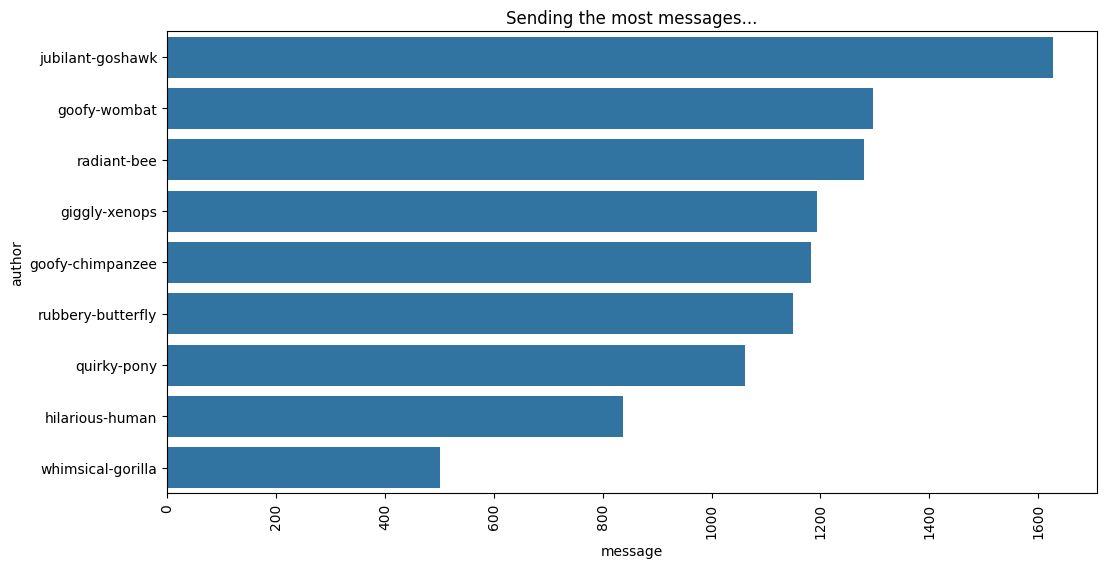

In [9]:
plt.figure(figsize=(12, 6))
sns.barplot(y=p1.index[:k], x="message", data=topk)
plt.xticks(rotation=90)
plt.title("Sending the most messages...")

Make overview of number of messages per day on average

In [22]:
df['day_of_week'] = df['timestamp'].dt.day_name()
df['date'] = df['timestamp'].dt.date
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df.head()

,timestamp,message,living_in_city,tech_background,has_emoji,emoji_count,word_count,react_time_sec,react_time_min,react_time_hr,...,is_removed_message,sentiment_polarity,sentiment_category,author,is_topk,date,weekday,day_of_week,year,month
0,2022-09-16 07:41:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,NaN,NaN,NaN,...,0,0.0,Neutral,goofy-chimpanzee,True,2022-09-16,Friday,Friday,2022,9
1,2022-09-16 08:21:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,2400.0,40.0,0.666667,...,0,0.0,Neutral,radiant-bee,True,2022-09-16,Friday,Friday,2022,9
2,2022-09-16 08:23:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,120.0,2.0,0.033333,...,0,0.0,Neutral,whimsical-gorilla,True,2022-09-16,Friday,Friday,2022,9
3,2022-09-16 09:08:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,2700.0,45.0,0.750000,...,0,0.0,Neutral,rubbery-butterfly,True,2022-09-16,Friday,Friday,2022,9
4,2022-09-16 09:23:00+00:00,Wachten op dit bericht,0,0,False,0,4.0,900.0,15.0,0.250000,...,0,0.0,Neutral,giggly-xenops,True,2022-09-16,Friday,Friday,2022,9


In [ ]:

analysis = df.groupby('weekday').agg(
    total_messages=('message', 'count'),
    unique_days=('date', 'nunique')
).reset_index()

analysis['average_messages_per_day'] = analysis['total_messages'] / analysis['unique_days']

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
analysis['weekday'] = pd.Categorical(analysis['weekday'], categories=weekday_order, ordered=True)
result = analysis.sort_values('weekday')[['weekday', 'average_messages_per_day']]

print(result)

     weekday  average_messages_per_day
1     Monday                 10.870968
5    Tuesday                 15.084337
6  Wednesday                 11.956522
4   Thursday                 15.228261
0     Friday                 14.834862
2   Saturday                 18.032258
3     Sunday                 15.587629


Add Median

In [17]:
# 2. Group by date and weekday to get the count of messages for each *unique* day
daily_counts = df.groupby(['date', 'day_of_week'])['timestamp'].size().reset_index(name='daily_message_count')

# 3. Group the daily counts by weekday and calculate the average and median
analysis = daily_counts.groupby('day_of_week')['daily_message_count'].agg(
    average_messages=('mean'),
    median_messages=('median')
).reset_index()

# 4. Sort the results in calendar order (optional)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
analysis['day_of_week'] = pd.Categorical(analysis['day_of_week'], categories=weekday_order, ordered=True)
result = analysis.sort_values('day_of_week')

print(result)

  day_of_week  average_messages  median_messages
1      Monday         10.881720              6.0
5     Tuesday         15.084337              7.0
6   Wednesday         11.989130              7.0
4    Thursday         15.228261              8.5
0      Friday         14.834862              9.0
2    Saturday         18.032258             12.0
3      Sunday         15.608247             11.0


Average and Median per Weekday per Year

    year day_of_week  average_messages  median_messages
1   2022      Monday         20.500000              8.0
5   2022     Tuesday         24.416667             15.0
6   2022   Wednesday          5.500000              5.0
4   2022    Thursday         19.300000              8.5
0   2022      Friday         20.181818              8.0
2   2022    Saturday         13.083333              9.5
3   2022      Sunday         12.888889              3.0
8   2023      Monday         12.470588              7.0
12  2023     Tuesday         11.172414              6.0
13  2023   Wednesday         11.787879              9.0
11  2023    Thursday         15.914286              8.0
7   2023      Friday         15.756757             13.0
9   2023    Saturday         19.170213             11.0
10  2023      Sunday         20.447368             14.5
15  2024      Monday         10.187500              7.0
19  2024     Tuesday         16.370370              7.0
20  2024   Wednesday         12.037037          

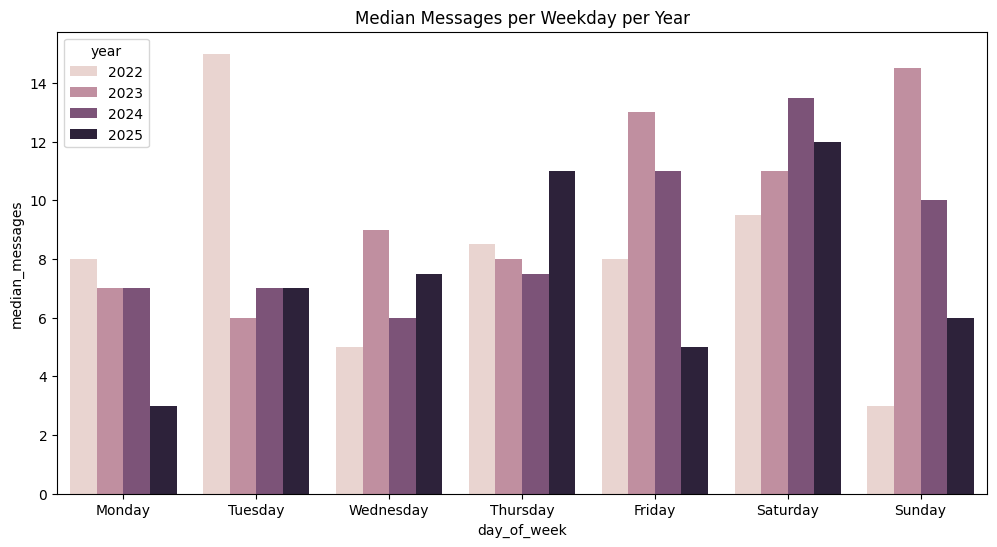

In [ ]:
# 2. Group by date and weekday to get the count of messages for each *unique* day
daily_counts = df.groupby(['date', 'day_of_week', 'year'])['timestamp'].size().reset_index(name='daily_message_count')

# 3. Group the daily counts by weekday and calculate the average and median
analysis = daily_counts.groupby(['year', 'day_of_week'])['daily_message_count'].agg(
    average_messages=('mean'),
    median_messages=('median')
).reset_index()

# 4. Sort the results in calendar order (optional)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
analysis['day_of_week'] = pd.Categorical(analysis['day_of_week'], categories=weekday_order, ordered=True)
result = analysis.sort_values(['year', 'day_of_week'])

graph = plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='median_messages', hue='year', data=result)
plt.title('Median Messages per Weekday per Year')

graph = plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='average_messages', hue='year', data=result)
plt.title('Average Messages per Weekday per Year')

print(result)



Activity per Month and Weekday

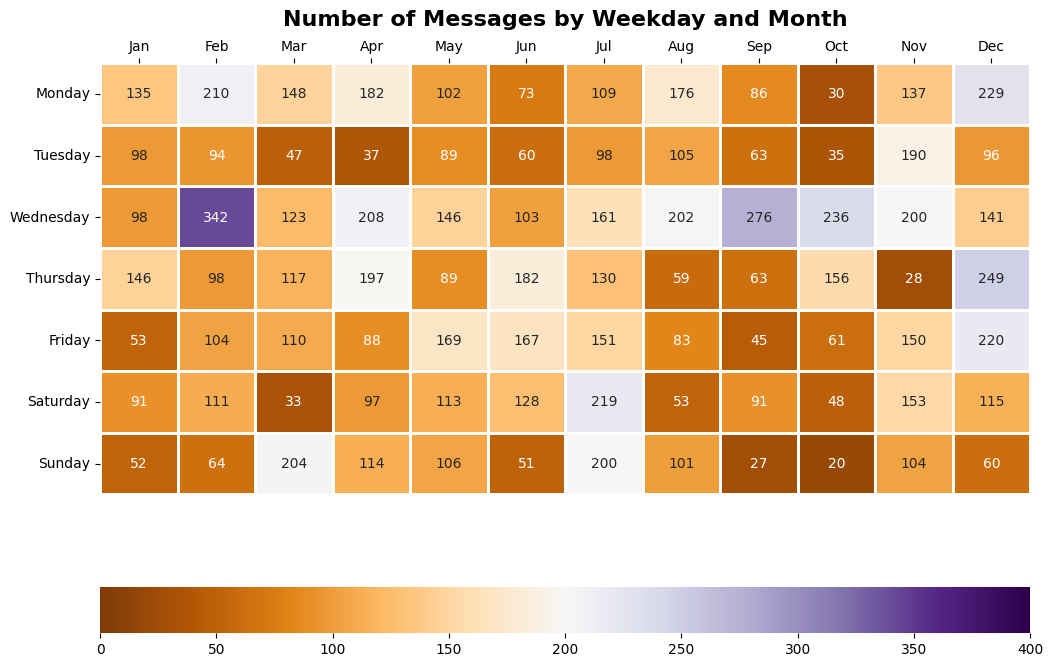

In [24]:
import calendar

DayMonth = df.groupby(['day_of_week','month']).size().reset_index(name='counts')

DayMonth_wide = DayMonth.pivot(index='day_of_week', columns='month', values='counts')
#Order columns and Index
month_order_abbr = list(calendar.month_abbr)
DayMonth_wide.columns = month_order_abbr[1:13]

day_order = list(calendar.day_name)
DayMonth_wide.index = day_order

plt.figure(figsize=(12,8))

ax = sns.heatmap(DayMonth_wide, annot=True, fmt='.0f', yticklabels='auto', cmap='PuOr', 
                 linewidths=1.8, cbar_kws={"orientation": "horizontal"},vmin = 0,vmax = 400)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.set_title('Number of Messages by Weekday and Month',fontsize = 16,weight = 'bold',pad=10)
plt.show()